# Neural Turing Machines: Tutorial


#### Step 1: Import libraries 

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from time import time
import torchvision.utils as vutils
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### COPY task for NMTs.

* We will perform copy task for NMTs. NMTs are powerful at performing algrothmic tasks which need to store and access information in memory and Copy task is perfect example of it. In this exercise how well NTM perfoems on Copy task.
The task is as follows. 
    * The NTM model is shown a random k-dimenstional vector for T-time steps.
    * The job of the network is output these T k-dimensional random vectors from zero-vectors at each time step.

### Controller

* Controller is 2-layer feedforward network. We can have an LSTM controller as well, bue due to simplicity we  build 2-layer fully connected controller. 

* Xavier initialization is used for parameter initilaization.

In [2]:
class FCController(nn.Module):
    def __init__(self, n_input, n_out, n_hidden):
        super(FCController, self).__init__()
        print("--Initialize fully connected controller--")
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_out)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize the linear layers
        nn.init.xavier_uniform_(self.fc1.weight, gain=1.4)
        nn.init.normal(self.fc1.bias, std=0.01)
        nn.init.xavier_uniform_(self.fc2.weight, gain=1.4)
        nn.init.normal(self.fc2.bias, std=0.01)

    def forward(self, x, last_read):
        x = torch.cat((x, last_read), dim=1)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

### Memory

* Memory M is a 2-D matrix, with M rows, and N columns
* the function address() does the the memory addressing which is composed of four functions
    * similarity
    * interpolation
    * shifting
    * sharpening
    
* For both read and write operation, it needs w_last to produce weights for current step. So, we keep track of weight_vector at each time step and save it in w_last.
* The function reset_memory() resets the memory for both read and write operations at start of new sequence (new input)

In [3]:
class Memory(nn.Module):
    def __init__(self, M, N, controller_out):
        super(Memory, self).__init__()

        self.N = N
        self.M = M
        self.read_lengths = self.N + 1 + 1 + 3 + 1
        self.write_lengths = self.N + 1 + 1 + 3 + 1 + self.N + self.N
        self.w_last = []
        self.reset_memory()

    def get_weights(self):
        return self.w_last

    def reset_memory(self):
        self.w_last = []
        self.w_last.append(torch.zeros([1, self.M], dtype=torch.float32))

    def address(self, k, beta, g, s, gamma, memory, w_last):
        # Content focus
        wc = self._similarity(k, beta, memory)
        # Location focus
        wg = self._interpolate(wc, g, w_last)
        w_hat = self._shift(wg, s)
        w = self._sharpen(w_hat, gamma)

        return w

    def _similarity(self, k, beta, memory):
        w = F.cosine_similarity(memory, k, -1, 1e-16)
        w = F.softmax(beta * w, dim=-1)
        return w

    def _interpolate(self, wc, g, w_last):
        return g * wc + (1 - g) * w_last

    def _shift(self, wg, s):
        result = torch.zeros(wg.size())
        result = _convolve(wg, s)
        return result

    def _sharpen(self, w_hat, gamma):
        w = w_hat ** gamma
        w = torch.div(w, torch.sum(w, dim=-1) + 1e-16)
        return w

### Read and Write operation
* In the next two cells we define read and write heads which access memory and updates memory according to read and 
write operations we discuss in chapter above
* Both read and write heads use fully connected layer to produce paremeters (k, beta, g, s, gamma) for content addressing. 

In [4]:
class ReadHead(Memory):

    def __init__(self, M, N, controller_out):
        super(ReadHead, self).__init__(M, N, controller_out)

        print("--Initialize Memory: ReadHead--")
        self.fc_read = nn.Linear(controller_out, self.read_lengths)
        self.reset_parameters();

    def reset_parameters(self):
        # Initialize the linear layers
        nn.init.xavier_uniform_(self.fc_read.weight, gain=1.4)
        nn.init.normal(self.fc_read.bias, std=0.01)

    def read(self, memory, w):
        """Read from memory."""
        return torch.matmul(w, memory)

    def forward(self, x, memory):
        param = self.fc_read(x)
        k, beta, g, s, gamma = torch.split(param, [self.N, 1, 1, 3, 1], dim=1)

        k = F.tanh(k)
        beta = F.softplus(beta)
        g = F.sigmoid(g)
        s = F.softmax(s, dim=1)
        gamma = 1 + F.softplus(gamma)

        w = self.address(k, beta, g, s, gamma, memory, self.w_last[-1])
        self.w_last.append(w)
        mem = self.read(memory, w)
        return mem, w


In [5]:
class WriteHead(Memory):

    def __init__(self, M, N, controller_out):
        super(WriteHead, self).__init__(M, N, controller_out)

        print("--Initialize Memory: WriteHead--")
        self.fc_write = nn.Linear(controller_out, self.write_lengths)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize the linear layers
        nn.init.xavier_uniform_(self.fc_write.weight, gain=1.4)
        nn.init.normal_(self.fc_write.bias, std=0.01)

    def write(self, memory, w, e, a):
        """write to memory."""
        w = torch.squeeze(w)
        e = torch.squeeze(e)
        a = torch.squeeze(a)

        erase = torch.ger(w, e)
        add = torch.ger(w, a)

        m_tilde = memory * (1 - erase)
        memory_update = m_tilde + add

        return memory_update

    def forward(self, x, memory):
        param = self.fc_write(x)

        k, beta, g, s, gamma, a, e = torch.split(param, [self.N, 1, 1, 3, 1, self.N, self.N], dim=1)

        k = F.tanh(k)
        beta = F.softplus(beta)
        g = F.sigmoid(g)
        s = F.softmax(s, dim=-1)
        gamma = 1 + F.softplus(gamma)
        a = F.tanh(a)
        e = F.sigmoid(e)

        w = self.address(k, beta, g, s, gamma, memory, self.w_last[-1])
        self.w_last.append(w)
        mem = self.write(memory, w, e, a)
        return mem, w


### Convolve is needed in the shifting step of content addressing 


In [6]:
def _convolve(w, s):
    """Circular convolution implementation."""
    b, d = s.shape
    assert b == 1, 'does _convolve work for b != 1?'
    assert d == 3
    w = torch.squeeze(w)
    t = torch.cat([w[-1:], w, w[:1]])
    c = F.conv1d(t.view(1, 1, -1), s.view(1, 1, -1)).view(b, -1)
    return c

### Define the network here which includes:
* fully connected controller
* read and write heads
* memory paramters
* utility functions to operate on memory which is not trainable

* In the forward function, X can be none. This is because in Copy task, training happens in two steps for one particular sequence
    * In the first step, the network is shown k-dimensional input for t time steps. 
    * In the second step (prediction step), the network takes in k-dimensional zeros vector to produce predictions which performs copy of the input for each time step.

In [7]:
class NTM(nn.Module):
    def __init__(self, M, N, num_inputs, num_outputs, controller_out_dim, controller_hid_dim):
        super(NTM, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.M = M
        self.N = N

        self.memory = torch.zeros(self.M, self.N)
        self.last_read = torch.zeros(1, self.N)

        self.controller = FCController(self.num_inputs + self.N, controller_out_dim, controller_hid_dim)
        self.read_head = ReadHead(self.M, self.N, controller_out_dim)
        self.write_head = WriteHead(self.M, self.N, controller_out_dim)

        self.fc_out = nn.Linear(self.num_inputs + N, self.num_outputs)
        self.reset_parameters()

    def forward(self, X=None):

        if X is None:
            X = torch.zeros(1, self.num_inputs)

        controller_out = self.controller(X, self.last_read)
        self._read_write(controller_out)

        out = torch.cat((X, self.last_read), -1)
        out = F.sigmoid(self.fc_out(out))

        return out

    def _read_write(self, controller_out):
        # READ
        read, w = self.read_head(controller_out, self.memory)
        self.last_read = read

        # WRITE
        mem, w = self.write_head(controller_out, self.memory)
        self.memory = mem

    def initalize_state(self):
        stdev = 1 / (np.sqrt(self.N + self.M))
        self.memory = nn.init.uniform_((torch.Tensor(self.M, self.N)), -stdev, stdev)
        self.last_read = F.tanh(torch.randn(1, self.N))

        self.read_head.reset_memory()
        self.write_head.reset_memory()

    def reset_parameters(self):
        # Initialize the linear layers
        nn.init.xavier_uniform_(self.fc_out.weight, gain=1.4)
        nn.init.normal_(self.fc_out.bias, std=0.5)

    def get_memory_info(self):
        return self.memory, self.read_head.get_weights(), self.write_head.get_weights()

    def calculate_num_params(self):
        """Returns the total number of parameters."""
        num_params = 0
        for p in self.parameters():
            num_params += p.data.view(-1).size(0)
        return num_params


### Data generation for COPY task

* A random sequence of vectors is preoduced which is to be copied by NTM model.
* A special token is appened at beginning and end of each sequence which marks sequence boundaries.

In [8]:
class BinaySeqDataset(Dataset):

    def __init__(self, args):
        self.seq_len = args['sequence_length']
        self.seq_width = args['token_size']
        self.dataset_dim = args['training_samples']

    def _generate_seq(self):
        seq = np.random.binomial(1, 0.5, (self.seq_len, self.seq_width))
        seq = torch.from_numpy(seq)
        # Add start and end token
        inp = torch.zeros(self.seq_len + 2, self.seq_width)
        inp[1:self.seq_len + 1, :self.seq_width] = seq.clone()
        inp[0, 0] = 1.0
        inp[self.seq_len + 1, self.seq_width - 1] = 1.0
        outp = seq.data.clone()

        return inp.float(), outp.float()

    def __len__(self):
        return self.dataset_dim

    def __getitem__(self, idx):
        inp, out = self._generate_seq()
        return inp, out

### Gradient clipping
* Its generally a good idea to clip gradients so that the network is numerically stable.

In [9]:
def clip_grads(net):
    parameters = list(filter(lambda p: p.grad is not None, net.parameters()))
    for p in parameters:
        p.grad.data.clamp_(args['min_grad'], args['max_grad'])

### Start training

In [10]:

args = {'sequence_length':300,'token_size':10,'memory_capacity':64,'memory_vector_size':128,'training_samples':99,
        'controller_output_dim':256,'controller_hidden_dim':512,'learning_rate':1e-4,'min_grad':-10,'max_grad':10,
       'logdir':'./','loadmodel':'','savemodel':'checkpoint.model'}
# writer = SummaryWriter()
dataset = BinaySeqDataset(args)
dataloader = DataLoader(dataset, batch_size=1,
                        shuffle=True, num_workers=4)

model = NTM(M=args['memory_capacity'],
            N=args['memory_vector_size'],
            num_inputs=args['token_size'],
            num_outputs=args['token_size'],
            controller_out_dim=args['controller_output_dim'],
            controller_hid_dim=args['controller_hidden_dim'],
            )

criterion = torch.nn.BCELoss()
# Here we use RMSProp optimizer. We can use Adam too.
optimizer = torch.optim.RMSprop(model.parameters(), lr=args['learning_rate'])

print("--------- Number of parameters -----------")
print(model.calculate_num_params())
print("--------- Start training -----------")

losses = []

if args['loadmodel'] != '':
    model.load_state_dict(torch.load(args['loadmodel']))

for e, (X, Y) in enumerate(dataloader):
    tmp = time()
    model.initalize_state()
    optimizer.zero_grad()

    inp_seq_len = args['sequence_length'] + 2
    out_seq_len = args['sequence_length']

    X.requires_grad = True

    # Input rete: sequenza
    for t in range(0, inp_seq_len):
        model(X[:, t])

    # Input rete: null
    y_pred = torch.zeros(Y.size())
    for i in range(0, out_seq_len):
        y_pred[:, i] = model()

    loss = criterion(y_pred, Y)
    loss.backward()
    clip_grads(model)
    optimizer.step()
    losses += [loss.item()]
    print("Loss: ", loss.item())

    # Lets train the network for 3000 iterations. 
    if e == 3000:
        break

#         if e % 50 == 0:
#             mean_loss = np.array(losses[-50:]).mean()
#             print("Loss: ", loss.item())
#             if e % 1000 == 0:
#                 mem_pic, read_pic, write_pic = model.get_memory_info()
#             losses = []


--Initialize fully connected controller--
--Initialize Memory: ReadHead--
--Initialize Memory: WriteHead--
--------- Number of parameters -----------
338554
--------- Start training -----------


/opt/anaconda3/envs/project09/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  if sys.path[0] == '':
/opt/anaconda3/envs/project09/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  
/opt/anaconda3/envs/project09/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  del sys.path[0]
/opt/anaconda3/envs/project09/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/anaconda3/envs/project09/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead

Loss:  0.8613712787628174
Loss:  0.7730068564414978
Loss:  0.7334338426589966
Loss:  0.7371690273284912
Loss:  0.7513346076011658
Loss:  0.7236287593841553
Loss:  0.7226125597953796
Loss:  0.7183470726013184
Loss:  0.7161100506782532
Loss:  0.7040868401527405
Loss:  0.6976701617240906
Loss:  0.6949153542518616
Loss:  0.695955753326416
Loss:  0.6930223703384399
Loss:  0.6924289464950562
Loss:  0.6922056674957275
Loss:  0.6938855648040771
Loss:  0.6932023167610168
Loss:  0.6931266188621521
Loss:  0.6931053996086121
Loss:  0.6941561698913574
Loss:  0.6926331520080566
Loss:  0.6925436854362488
Loss:  0.6925121545791626
Loss:  0.6946836113929749
Loss:  0.6917170286178589
Loss:  0.691535234451294
Loss:  0.69150310754776
Loss:  0.6942601203918457
Loss:  0.6921616792678833
Loss:  0.692095160484314
Loss:  0.6920585036277771
Loss:  0.6939138174057007
Loss:  0.6931183338165283
Loss:  0.6930879950523376
Loss:  0.6931377053260803
Loss:  0.6949366927146912
Loss:  0.6913498640060425
Loss:  0.69117236

### Plotting

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

In [12]:
def plot_signal(grid_image, fig_size=(500,100)):
    plt.figure(figsize=fig_size)
    plt.imshow(grid_image.data.permute(2, 1, 0))

### Training loss


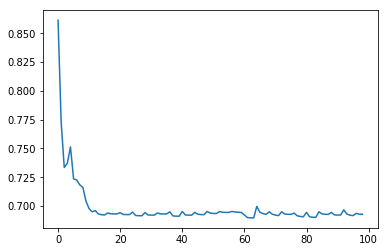

In [13]:
plt.plot(losses)
plt.show()

### COPY signal
* Here we create a random signal of 300 time steps and see how well the model copies this signal.


In [14]:
X, Y = dataset._generate_seq()
X = X.unsqueeze(0) # Add the batch dimension
Y = Y.unsqueeze(0)

model.initalize_state()

for t in range(0, inp_seq_len):
    model(X[:, t])

y_pred = torch.zeros(Y.size())
for i in range(0, out_seq_len):
    y_pred[:, i] = model()

/opt/anaconda3/envs/project09/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/opt/anaconda3/envs/project09/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


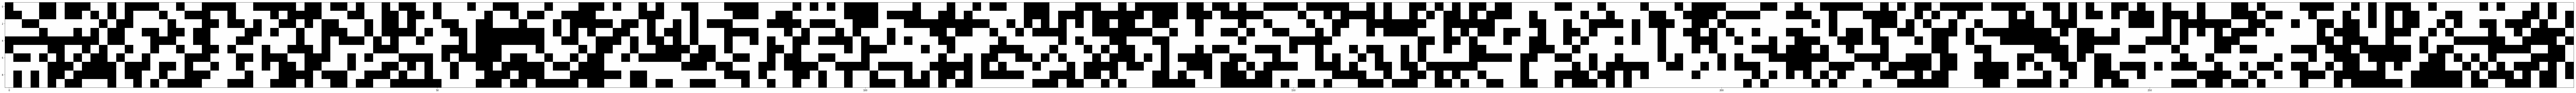

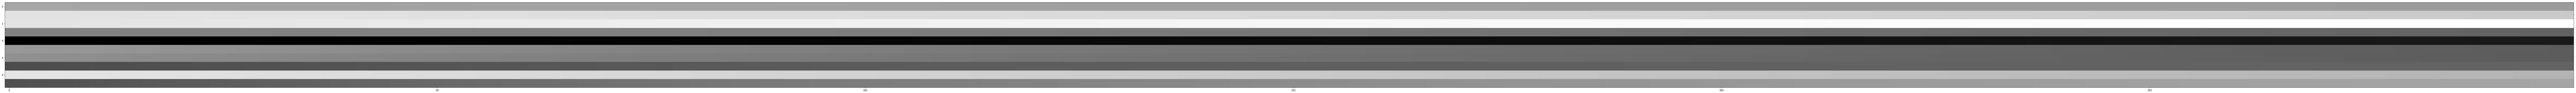

In [15]:
# Plot ground truth signal Y and signal y_pred predicted by model.
# In Copy task these two signals should be very close. 

grid_img_truth = vutils.make_grid(Y, normalize=True, scale_each=True)
grid_img_pred = vutils.make_grid(y_pred, normalize=True, scale_each=True)

plt.figure(figsize=(200,200))
plt.imshow(grid_img_truth.data.permute(2, 1, 0))

plt.figure(figsize=(200,200))
plt.imshow(grid_img_pred.data.permute(2, 1, 0))


### Read, Write and Memory visualizations

* We will see visualizations of read and write operations which will tell us where the read and write heads focus at each time step.


In [16]:
mem_pic, read_pic, write_pic = model.get_memory_info()

In [17]:
grid_mem = vutils.make_grid(mem_pic, normalize=True, scale_each=True)
grid_read = vutils.make_grid(read_pic, normalize=True, scale_each=True)
grid_write = vutils.make_grid(write_pic, normalize=True, scale_each=True)

In [18]:
grid_img_pred.shape

torch.Size([3, 300, 10])

TypeError: Invalid dimensions for image data

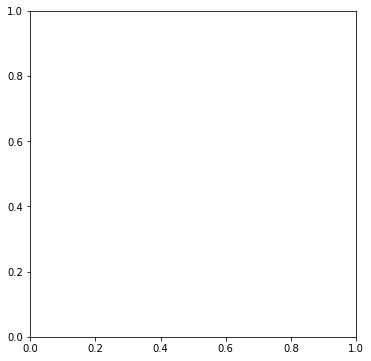

In [19]:
plot_signal(grid_read, fig_size=(10,6))

In [20]:
read_pic[0].shape

torch.Size([1, 64])

In [21]:
X.shape

torch.Size([1, 302, 10])